**Import Library**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, silhouette_score
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

In [65]:
df = pd.read_csv('customer_segmentation_data.csv')
df.head(10)

,Customer_ID,DOB,Gender,Annual_Income,Spending_Score,Shopping_Category,Shopping_Frequency,Total_Spent
0,CUST0001,2000-05-16,Female,119743.0,10.0,Clothing,24,287.38
1,CUST0002,1965-06-08,Female,60585.0,77.0,Clothing,22,1026.31
2,CUST0003,1945-05-24,Female,66680.0,29.0,Groceries,25,483.43
3,CUST0004,1986-03-29,Female,119682.0,55.0,Electronics,10,658.25
4,CUST0005,1983-11-26,Male,67754.0,51.0,Toys,2,69.11
5,CUST0006,1998-05-29,Female,133923.0,57.0,Clothing,23,1755.73
6,CUST0007,1977-09-19,male,54064.0,67.0,Groceries,17,615.79
7,CUST0008,1963-03-17,M,47810.0,100.0,Toys,26,1243.06
8,CUST0009,2000-06-03,Female,68413.0,78.0,Toys,15,800.43
9,CUST0010,2001-10-15,Female,53421.0,19.0,Sports,25,253.75


In [66]:
df.dtypes

Customer_ID            object
DOB                    object
Gender                 object
Annual_Income         float64
Spending_Score        float64
Shopping_Category      object
Shopping_Frequency      int64
Total_Spent           float64
dtype: object

# 1. Data Cleaning

In [67]:
numeric = ['Annual_Income','Spending_Score','Shopping_Frequency','Total_Spent']

for i in numeric:
    Q1 = df[i].quantile(0.25)
    Q3 = df[i].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outlier = df[(df[i] < lower) | (df[i] > upper)]
    print(f"Kolom {i} : {len(outlier)} outlier")

Kolom Annual_Income : 0 outlier
Kolom Spending_Score : 0 outlier
Kolom Shopping_Frequency : 0 outlier
Kolom Total_Spent : 18 outlier


In [68]:
df['Total_Spent'].skew()

1.553149102511463

**Winzorization**

In [69]:
Q1 = df['Total_Spent'].quantile(0.25)
Q3 = df['Total_Spent'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Total_Spent'] = np.where(df['Total_Spent'] < lower_bound, lower_bound, df['Total_Spent'])
df['Total_Spent'] = np.where(df['Total_Spent'] > upper_bound, upper_bound, df['Total_Spent'])

In [70]:
df.isna().sum()

Customer_ID            0
DOB                    0
Gender                10
Annual_Income         21
Spending_Score        24
Shopping_Category     56
Shopping_Frequency     0
Total_Spent           44
dtype: int64

**Add Missing Values**

In [71]:
df['Total_Spent'] = df['Total_Spent'].fillna(df['Total_Spent'].median())
df['Annual_Income'] = df['Annual_Income'].fillna(df['Annual_Income'].mean())
df['Spending_Score'] = df['Spending_Score'].fillna(df['Spending_Score'].mean())
df['Shopping_Frequency'] = df['Shopping_Frequency'].fillna(df['Shopping_Frequency'].mean())
df['Shopping_Category'] = df['Shopping_Category'].fillna(df['Shopping_Category'].mode()[0])

In [72]:
df['Spending_Score'] = df['Spending_Score'].astype(int)
df['DOB'] = pd.to_datetime(df['DOB'], errors='coerce')


**Standarize Gender only Male and Female**

In [73]:
df['Gender'] = df['Gender'].str.strip().str.lower()
df['Gender'] =df['Gender'].replace({
    'male' : 'Male', 'm' : 'Male', 
    'female' : 'Female', 'f' : 'Female'
})

df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])


**Encoding Categorical Data**

In [74]:
# 0 = Female ; 1 = Male
encoder = LabelEncoder()
df['Gender'] = encoder.fit_transform(df['Gender'])

df.head(10)

,Customer_ID,DOB,Gender,Annual_Income,Spending_Score,Shopping_Category,Shopping_Frequency,Total_Spent
0,CUST0001,2000-05-16,0,119743.0,10,Clothing,24,287.38
1,CUST0002,1965-06-08,0,60585.0,77,Clothing,22,1026.31
2,CUST0003,1945-05-24,0,66680.0,29,Groceries,25,483.43
3,CUST0004,1986-03-29,0,119682.0,55,Electronics,10,658.25
4,CUST0005,1983-11-26,1,67754.0,51,Toys,2,69.11
5,CUST0006,1998-05-29,0,133923.0,57,Clothing,23,1755.73
6,CUST0007,1977-09-19,1,54064.0,67,Groceries,17,615.79
7,CUST0008,1963-03-17,1,47810.0,100,Toys,26,1243.06
8,CUST0009,2000-06-03,0,68413.0,78,Toys,15,800.43
9,CUST0010,2001-10-15,0,53421.0,19,Sports,25,253.75


In [75]:
df.dtypes

Customer_ID                   object
DOB                   datetime64[ns]
Gender                         int32
Annual_Income                float64
Spending_Score                 int32
Shopping_Category             object
Shopping_Frequency             int64
Total_Spent                  float64
dtype: object

In [76]:
df.duplicated().sum()

0

In [77]:
df[numeric].describe()

,Annual_Income,Spending_Score,Shopping_Frequency,Total_Spent
count,500.000000,500.000000,500.000000,500.000000
mean,85045.271399,52.460000,15.004000,648.787620
std,35413.542329,28.299862,8.896194,636.294331
min,20506.000000,1.000000,1.000000,0.690000
25%,57560.000000,28.000000,7.000000,180.880000
50%,85045.271399,52.000000,15.000000,410.965000
75%,112883.500000,77.000000,23.000000,933.330000
max,149630.000000,100.000000,30.000000,2344.190000


In [78]:
df['Age'] = datetime.now().year - df['DOB'].dt.year

In [79]:
df['Avg Spending Per Transaction'] = df['Spending_Score'] / df['Total_Spent']

In [80]:
df.head()

,Customer_ID,DOB,Gender,Annual_Income,Spending_Score,Shopping_Category,Shopping_Frequency,Total_Spent,Age,Avg Spending Per Transaction
0,CUST0001,2000-05-16,0,119743.0,10,Clothing,24,287.38,25,0.034797
1,CUST0002,1965-06-08,0,60585.0,77,Clothing,22,1026.31,60,0.075026
2,CUST0003,1945-05-24,0,66680.0,29,Groceries,25,483.43,80,0.059988
3,CUST0004,1986-03-29,0,119682.0,55,Electronics,10,658.25,39,0.083555
4,CUST0005,1983-11-26,1,67754.0,51,Toys,2,69.11,42,0.737954


In [81]:
df[numeric].describe()

,Annual_Income,Spending_Score,Shopping_Frequency,Total_Spent
count,500.000000,500.000000,500.000000,500.000000
mean,85045.271399,52.460000,15.004000,648.787620
std,35413.542329,28.299862,8.896194,636.294331
min,20506.000000,1.000000,1.000000,0.690000
25%,57560.000000,28.000000,7.000000,180.880000
50%,85045.271399,52.000000,15.000000,410.965000
75%,112883.500000,77.000000,23.000000,933.330000
max,149630.000000,100.000000,30.000000,2344.190000


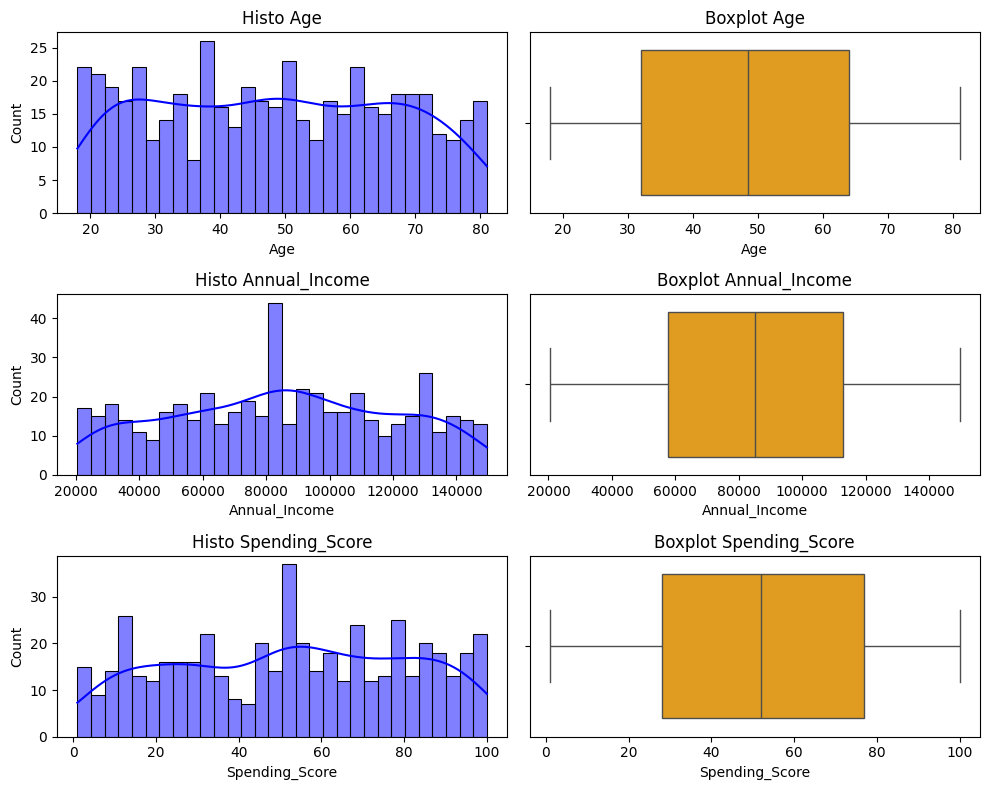

In [82]:
features = ['Age','Annual_Income','Spending_Score']

plt.figure(figsize=(10,8))

for i, j in enumerate(features, 1):
    plt.subplot(3,2,2*i-1)
    sns.histplot(df[j], bins=30, kde=True, color='Blue')
    plt.title(f'Histo {j}')

    plt.subplot(3,2,2*i)
    sns.boxplot(x=df[j], color='orange')
    plt.title(f'Boxplot {j}')

plt.tight_layout()
plt.show()

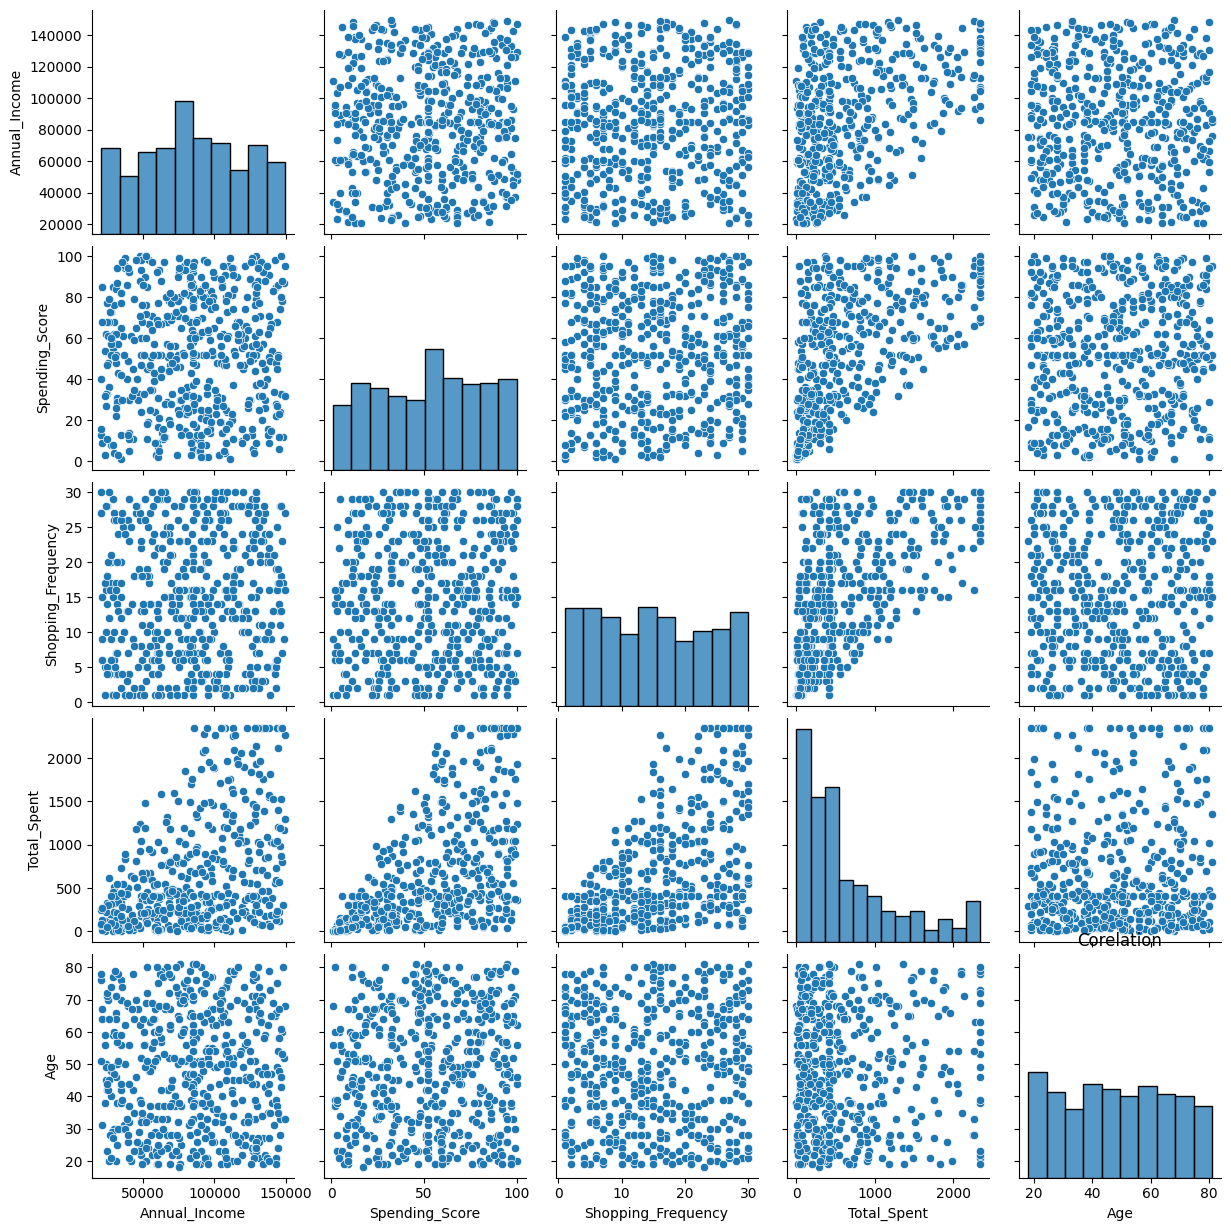

In [83]:
numeric.append('Age')
sns.pairplot(df[numeric])
plt.title('Corelation')
plt.show()

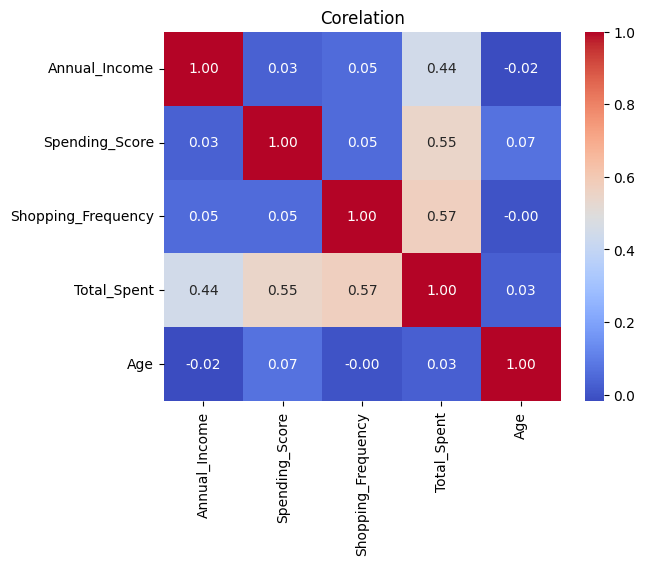

In [84]:
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corelation')
plt.show()

In [85]:
lower_treshold = df['Total_Spent'].quantile(0.25)
upper_treshold = df['Total_Spent'].quantile(0.75)

def categorize(x):
    if x <= lower_treshold:
        return 'Low Spender'
    elif x <= upper_treshold:
        return 'Mid Spender'
    else:
        return 'High Spender'
    
df['Spender_Category'] = df['Total_Spent'].apply(categorize)

In [86]:
lower_freq = df['Shopping_Frequency'].quantile(0.25)
upper_freq = df['Shopping_Frequency'].quantile(0.75)

def freq_categorize(x):
    if x <= lower_freq:
        return 'Rare Shopper'
    elif x <= upper_freq:
        return 'Occasional Shopper'
    else :
        return 'Frequent Shopper'
    
df['Shopper_Category'] = df['Shopping_Frequency'].apply(freq_categorize)

In [87]:
df.head()

,Customer_ID,DOB,Gender,Annual_Income,Spending_Score,Shopping_Category,Shopping_Frequency,Total_Spent,Age,Avg Spending Per Transaction,Spender_Category,Shopper_Category
0,CUST0001,2000-05-16,0,119743.0,10,Clothing,24,287.38,25,0.034797,Mid Spender,Frequent Shopper
1,CUST0002,1965-06-08,0,60585.0,77,Clothing,22,1026.31,60,0.075026,High Spender,Occasional Shopper
2,CUST0003,1945-05-24,0,66680.0,29,Groceries,25,483.43,80,0.059988,Mid Spender,Frequent Shopper
3,CUST0004,1986-03-29,0,119682.0,55,Electronics,10,658.25,39,0.083555,Mid Spender,Occasional Shopper
4,CUST0005,1983-11-26,1,67754.0,51,Toys,2,69.11,42,0.737954,Low Spender,Rare Shopper


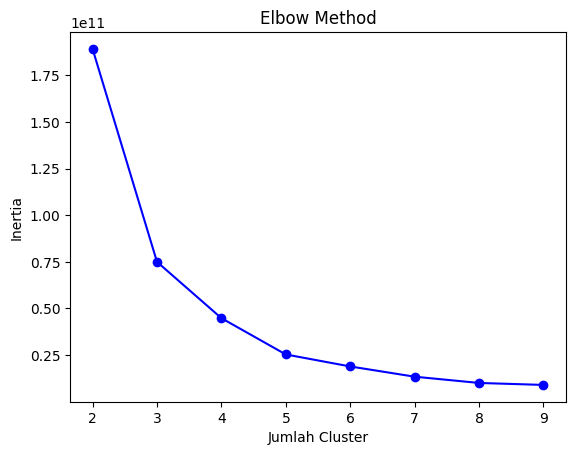

In [88]:
numeric.append('Avg Spending Per Transaction')
iner = []
k = range(2,10)

for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df[numeric])
    iner.append(kmeans.inertia_)

plt.plot(k, iner, 'bo-')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [93]:
kmeans = KMeans(n_clusters=5,random_state=42)
df['Cluster'] = kmeans.fit_predict(df[numeric])

In [94]:
score = silhouette_score(df[numeric],df['Cluster'])
print(f'Silhouette Score : {score}')

Silhouette Score : 0.5829368621407153


In [96]:
df

,Customer_ID,DOB,Gender,Annual_Income,Spending_Score,Shopping_Category,Shopping_Frequency,Total_Spent,Age,Avg Spending Per Transaction,Spender_Category,Shopper_Category,Cluster
0,CUST0001,2000-05-16,0,119743.0,10,Clothing,24,287.38,25,0.034797,Mid Spender,Frequent Shopper,3
1,CUST0002,1965-06-08,0,60585.0,77,Clothing,22,1026.31,60,0.075026,High Spender,Occasional Shopper,4
2,CUST0003,1945-05-24,0,66680.0,29,Groceries,25,483.43,80,0.059988,Mid Spender,Frequent Shopper,4
3,CUST0004,1986-03-29,0,119682.0,55,Electronics,10,658.25,39,0.083555,Mid Spender,Occasional Shopper,3
4,CUST0005,1983-11-26,1,67754.0,51,Toys,2,69.11,42,0.737954,Low Spender,Rare Shopper,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,CUST0496,1959-07-29,0,95165.0,33,Clothing,6,188.43,66,0.175131,Mid Spender,Rare Shopper,0
496,CUST0497,2000-08-13,0,60542.0,31,Furniture,1,18.77,25,1.651572,Low Spender,Rare Shopper,4
497,CUST0498,1992-04-18,0,94808.0,36,Groceries,23,785.01,33,0.045859,Mid Spender,Occasional Shopper,0
498,CUST0499,2006-09-05,1,125951.0,97,Furniture,15,1832.59,19,0.052931,High Spender,Occasional Shopper,1
